# Sklearn models

In [1]:
import json
import os
import pickle
import random
import warnings

import matplotlib.pyplot as plt

from scipy.sparse import hstack
from scipy.sparse.csr import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.utils import shuffle
from joblib import dump, load
from xgboost import XGBClassifier

from sarcsdet.configs.sklearn_models_config import *
from sarcsdet.configs.sklearn_models_grid_search_params import *
from sarcsdet.models.count_model_metrics import *

In [2]:
warnings.filterwarnings('ignore')

## Get data

In [3]:
data_path = '../data/Quotes'

In [4]:
with open(os.path.join(data_path, 'quotes_ling_feats.pickle'), 'rb') as f:
    df = shuffle(pickle.load(f), random_state=8)

In [5]:
# # percentage of the data
# df = df.sample(frac=0.5)

In [6]:
# # get balanced data
# df = df.groupby(
#     'target', group_keys=False
# ).apply(lambda x: x.sample(n=(df.target == 1).sum())).sample(frac=1).reset_index(drop=True)

In [7]:
# split data to train and test
train_df, test_df = train_test_split(df, test_size=0.3, random_state=8)

## Random

In [8]:
y_test = test_df.target
y_pred = [random.choice([0, 1]) for y in y_test]
y_pred_prob = [random.random() for y in y_test]

show_test_classification_metrics(y_test, y_pred, y_pred_prob)

F1: 0.11991
PREC: 0.068208
PR-AUC: 0.069615
ROC-AUC: 0.50101
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.50      0.65    111669
           1       0.07      0.50      0.12      8299

    accuracy                           0.50    119968
   macro avg       0.50      0.50      0.38    119968
weighted avg       0.87      0.50      0.61    119968

-------------------------------------------------------


## Train Sklearn models

In [9]:
result_path = '../results/quotes'

In [10]:
unsorted_scores = []

for filename in os.listdir(result_path):
    if filename.endswith('.json'):
        with open(os.path.join(result_path, filename)) as f:
            unsorted_scores.append(json.loads(f.read()))

In [11]:
scores_df = pd.io.json.json_normalize(unsorted_scores)
scores_df.rename(columns={
    'results.precision': 'precision', 'results.recall': 'recall', 'results.F1': 'F1', 
    'results.PR AUC': 'PR_AUC', 'results.ROC AUC': 'ROC_AUC'}, inplace=True
    )
scores_df.drop(columns=['seed', 'test samples'], axis=1, inplace=True)

In [12]:
scores_df = scores_df[scores_df['recall'] > 0.5]
scores_df = scores_df[scores_df['precision'] > 0.06]
scores_df = scores_df[scores_df['F1'] > 0.12]
scores_df = scores_df[scores_df['ROC_AUC'] > 0.55]

In [13]:
pd.set_option('display.max_colwidth', df.shape[0] + 1)
scores_df.sort_values(by=['precision'], ascending=False).head(15)

,embedding,model,extra_features,precision,recall,F1,PR_AUC,ROC_AUC
5,TFIDF,LogisticRegression,"[funny_mark, interjections, exclamation, question, quotes, dotes, rating, comments_count, source, submitted_by]",0.149250,0.546572,0.234473,0.158947,0.731090
14,TFIDF,LogisticRegression,"[exclamation, question, quotes, dotes]",0.145792,0.517412,0.227485,0.151875,0.721882
44,TFIDF,LogisticRegression,[funny_mark],0.142843,0.512953,0.223459,0.149969,0.717639
51,TFIDF,LogisticRegression,[],0.142795,0.512712,0.223377,0.150001,0.717644
35,TFIDF,LogisticRegression,[interjections],0.142459,0.511387,0.222841,0.150029,0.717831
88,Word2Vec,LogisticRegression,[],0.140649,0.528497,0.222172,0.139955,0.714404
76,NatashaGlove,BernoulliNB,"[funny_mark, interjections, exclamation, question, quotes, dotes, rating, comments_count, source, submitted_by]",0.123483,0.641403,0.207096,0.126188,0.698453
107,NatashaGlove,Perceptron,[],0.098646,0.529341,0.166301,0.084776,0.584943
54,NatashaGlove,LogisticRegression,[],0.095260,0.629353,0.165473,0.106479,0.630134
83,Word2Vec,Perceptron,[],0.089873,0.743343,0.160359,0.084561,0.591952


## Get parameters for best Sklearn model

In [14]:
tfidf = TfidfVectorizer(
    ngram_range=(1, 3), 
    max_features=50000,
    min_df=2
)

In [15]:
X = tfidf.fit_transform(train_df.quote_tokenized)
y = train_df.target.values

In [16]:
current_extra_features = [
    'funny_mark', 'interjections', 
    'exclamation', 'question', 'quotes', 'dotes',
    'rating', 'comments_count', 'source',  'submitted_by'
]

extra_features_data = csr_matrix(train_df[current_extra_features].values.astype(np.float))
X = hstack([X, extra_features_data], format='csr')

In [17]:
cv = KFold(n_splits=5, shuffle=True)

In [18]:
clf = LogisticRegression(**default_logit_params_rus)  # --> lr_grid
# clf = XGBClassifier(**default_xgb_params_rus)  # --> xgb_grid
# clf = BernoulliNB(**default_bayes_params_rus)  # --> nb_grid

In [19]:
scoring = {
    'custom': make_scorer(custom_scorer),
    'PREC': 'precision',
    'PR_AUC': 'average_precision',
    'AUC': 'roc_auc',  
    'F1': 'f1_weighted'
}

In [20]:
gs = GridSearchCV(
    clf, lr_grid, 
    scoring=scoring, cv=cv, 
    refit='custom',
    verbose=10, n_jobs=6
)

In [21]:
search = gs.fit(X, y)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


In [22]:
best_estimator = gs.best_estimator_
best_estimator

LogisticRegression(C=0.1, class_weight='balanced', multi_class='ovr', n_jobs=-2,
                   solver='newton-cg')

In [23]:
get_best_model_metrics(X, y, cv, best_estimator)


F1: 0.23093
ROC-AUC: 0.73831
ACCURACY: 0.71127
PR-AUC: 0.15689


F1: 0.23328
PREC: 0.14339
PR-AUC: 0.15659
ROC-AUC: 0.7391
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.72      0.83    111669
           1       0.14      0.63      0.23      8299

    accuracy                           0.72    119968
   macro avg       0.55      0.67      0.53    119968
weighted avg       0.91      0.72      0.78    119968

-------------------------------------------------------


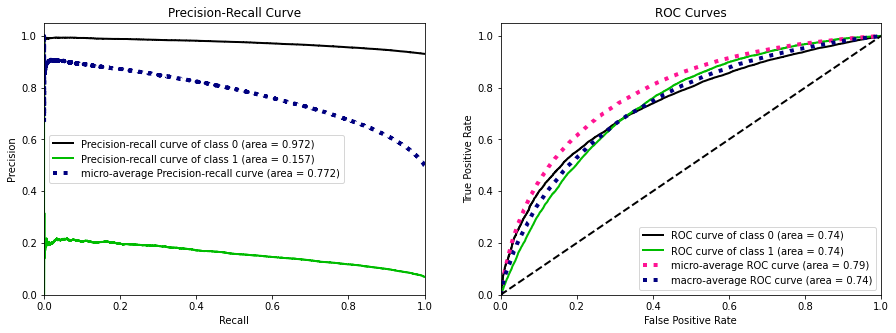

In [24]:
X_test = tfidf.transform(test_df.quote_tokenized)

test_extra_features_data = csr_matrix(test_df[current_extra_features].values.astype(np.float))
X_test = hstack([X_test, test_extra_features_data], format='csr')


probas = best_estimator.predict_proba(X_test)
show_test_classification_metrics(
    test_df.target.values, 
    best_estimator.predict(X_test), 
    probas[:, 1], 
    X_test, 
    best_estimator,
    probas,
)

In [25]:
dump(tfidf, '../data/Models/quotes/tfidf.joblib')

['../data/Models/quotes/tfidf.joblib']

In [26]:
dump(best_estimator, '../data/Models/quotes/LogisticRegression.joblib')

['../data/Models/quotes/LogisticRegression.joblib']